In [6]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("/work/git/script_Hi-C")
from HiCmodule import *
from PlotModule import *
from DirectionalFreqRatio import *
from Cluster import *

import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import ndimage

cm = generate_cmap(['#1310cc', '#FFFFFF', '#d10a3f'])
Mega = 1000000

In [7]:
resolution = 25000
resolution_merge = 25000
normalizetype="RPM"

def loadJuicerData(dirname, type):
    return JuicerMatrix(normalizetype,
                        "/work2/Hi-C/Sakata_RPE/JuicerResults_20210517/" + dirname + "/Matrix/intrachromosomal/"
                        + str(resolution) + "/observed."  + type + "." + chr + ".matrix.gz", 
                        resolution)

def loadJuicerData_merged(dirname, type):
    return JuicerMatrix(normalizetype,
                        "/work2/Hi-C/Sakata_RPE/JuicerResults_merged_20210517/" + dirname + "/mega/Matrix/intrachromosomal/"
                        + str(resolution_merge) + "/observed."  + type + "." + chr + ".matrix.gz", 
                        resolution)


norm = "VC_SQRT"

In [8]:
pd.set_option('display.max_rows', 100)
beds = pd.read_csv("diffDFRregions/DFRdiff.genome.thre0.7.tsv",sep="\t",header=None).sort_values(0)
beds

,0,1,2,3,4
173,chr1,193350000,193425000,-0.739769,0.739769
234,chr1,192400000,192425000,0.702831,0.702831
181,chr1,193175000,193225000,-0.731495,0.731495
230,chr1,190850000,190875000,-0.703933,0.703933
156,chr10,77625000,77725000,0.747909,0.747909
...,...,...,...,...,...
223,chr9,99200000,99250000,-0.707106,0.707106
102,chr9,15800000,15900000,-0.795156,0.795156
197,chr9,118550000,118600000,-0.720660,0.720660
31,chr9,6800000,7100000,-0.940121,0.940121


In [ ]:
from scipy import spatial
chr = ""

labels = ["Rad21KD_merged", "NIPBLKD_merged", "Mau2KD", "CTCFKD_merged", "ESCO1KD_merged",
          "WAPLKD", "PDS5AKD_72h", "PDS5BKD", "PDS5ABKD", "JQ1_plus"]

csim = pd.DataFrame(index=labels, columns=labels, data=0)

corarray = pd.DataFrame(index=csim.corr().unstack().index)
corarray

for index, row in beds.iterrows():
    if row[0] != chr:
        chr = row[0]
        Jdata = {}

        for i, sample in enumerate(["Mau2KD", "WAPLKD", "PDS5ABKD", "PDS5AKD_72h", "PDS5BKD", "JQ1_plus"]):
            Jdata[sample] = loadJuicerData(sample, norm)
    
        Jdata["Control_merged"] = loadJuicerData_merged("Control", norm)
        Jdata["CTCFKD_merged"] = loadJuicerData_merged("CTCFKD", norm)
        Jdata["Rad21KD_merged"] = loadJuicerData_merged("Rad21KD", norm)
        Jdata["NIPBLKD_merged"] = loadJuicerData_merged("NIPBLKD", norm)
        Jdata["ESCO1KD_merged"] = loadJuicerData_merged("ESCO1KD", norm)
        
        Jdatalist = [Jdata["Control_merged"]]
        for label in labels:
            Jdatalist.append(Jdata[label])
        
        Combined = make3dmatrixRatio(Jdatalist)

    center = int(((row[2]+row[1])/2)/resolution)*resolution
    figstart = center - 2000000
    figend = center + 2000000
    s = int(figstart / resolution)
    e = int(figend   / resolution)
    center = int((s+e)/2)

    print (figstart, figend, s, e)
    plt.figure(figsize=(12, 6))
    for i in range(len(labels)):
        ax = plt.subplot(2, 5, i+1)
        ax.imshow(Combined[i,s:e,s:e], clim=(-1, 1), cmap=cm)
        ax.set_title(labels[i])
        axxticks(ax, 0,e-s, figstart, figend, 5)
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

    array = pd.DataFrame(columns=labels)
    for i in range(len(labels)):
        array[labels[i]] = Combined[i,s:e,s:e].flatten()
    
    csim = pd.DataFrame(index=labels, columns=labels, data=0)

    for l1 in labels:
        for l2 in labels:
            csim.loc[l1,l2] = 1 - spatial.distance.cosine(array[l1], array[l2])
   
    sns.heatmap(csim, cmap="RdBu_r", vmin=-1, vmax=1, square=True)
    plt.show()
    
    a = csim.corr().unstack()
    corarray = pd.concat([corarray, a], axis=1)

In [11]:
corarray

0         0         0         0  \
Rad21KD_merged Rad21KD_merged  1.000000  1.000000  1.000000  1.000000   
               NIPBLKD_merged  0.991416  0.994982  0.993070  0.964971   
               Mau2KD          0.972872  0.970015  0.975402  0.905845   
               CTCFKD_merged  -0.010259  0.412712  0.083524  0.718137   
               ESCO1KD_merged -0.680146 -0.796846 -0.683816 -0.277286   
               WAPLKD         -0.772804 -0.832194 -0.768431 -0.482713   
               PDS5AKD_72h    -0.735876 -0.616919 -0.734497 -0.217481   
               PDS5BKD        -0.633646 -0.662656 -0.622258 -0.266076   
               PDS5ABKD       -0.819787 -0.723858 -0.816890  0.071128   
               JQ1_plus       -0.245077 -0.049414 -0.270423 -0.252478   
NIPBLKD_merged Rad21KD_merged  0.991416  0.994982  0.993070  0.964971   
               NIPBLKD_merged  1.000000  1.000000  1.000000  1.000000   
               Mau2KD          0.986019  0.971356  0.986097  0.890428   
               CTCFKD_merged  -0.075646  0.407996  0.021272  0.709181   
               ESCO1KD_merged -0.723348 -0.830977 -0.718506 -0.491491   
               WAPLKD         -0.804091 -0.860016 -0.792112 -0.652315   
               PDS5AKD_72h    -0.735142 -0.628052 -0.730472 -0.286190   
               PDS5BKD        -0.681749 -0.711237 -0.661728 -0.473333   
               PDS5ABKD       -0.854870 -0.759307 -0.844797 -0.157510   
               JQ1_plus       -0.177541  0.018109 -0.214690 -0.030338   
Mau2KD         Rad21KD_merged  0.972872  0.970015  0.975402  0.905845   
               NIPBLKD_merged  0.986019  0.971356  0.986097  0.890428   
               Mau2KD          1.000000  1.000000  1.000000  1.000000   
               CTCFKD_merged  -0.116926  0.312021 -0.014198  0.609045   
               ESCO1KD_merged -0.710355 -0.769178 -0.706432 -0.272293   
               WAPLKD         -0.783982 -0.798028 -0.773345 -0.464403   
               PDS5AKD_72h    -0.726346 -0.580141 -0.724394 -0.249247   
               PDS5BKD        -0.680150 -0.641709 -0.662194 -0.277554   
               PDS5ABKD       -0.852910 -0.712178 -0.843918 -0.001424   
               JQ1_plus       -0.179794 -0.057351 -0.214623 -0.191425   
CTCFKD_merged  Rad21KD_merged -0.010259  0.412712  0.083524  0.718137   
               NIPBLKD_merged -0.075646  0.407996  0.021272  0.709181   
               Mau2KD         -0.116926  0.312021 -0.014198  0.609045   
               CTCFKD_merged   1.000000  1.000000  1.000000  1.000000   
               ESCO1KD_merged -0.206299 -0.629680 -0.283344 -0.246508   
               WAPLKD         -0.248280 -0.639081 -0.336735 -0.587556   
               PDS5AKD_72h    -0.353726 -0.751102 -0.436787 -0.277446   
               PDS5BKD        -0.200095 -0.594180 -0.279954 -0.459213   
               PDS5ABKD       -0.097265 -0.630689 -0.197779  0.062091   
               JQ1_plus        0.164656  0.289644  0.150349 -0.077849   
ESCO1KD_merged Rad21KD_merged -0.680146 -0.796846 -0.683816 -0.277286   
               NIPBLKD_merged -0.723348 -0.830977 -0.718506 -0.491491   
               Mau2KD         -0.710355 -0.769178 -0.706432 -0.272293   
               CTCFKD_merged  -0.206299 -0.629680 -0.283344 -0.246508   
               ESCO1KD_merged  1.000000  1.000000  1.000000  1.000000   
               WAPLKD          0.872894  0.896160  0.867874  0.717533   
               PDS5AKD_72h     0.725779  0.770023  0.736713  0.322212   
               PDS5BKD         0.853596  0.870419  0.845164  0.777734   
               PDS5ABKD        0.805852  0.865216  0.804645  0.694503   
               JQ1_plus       -0.403420 -0.465141 -0.379573 -0.708103   
WAPLKD         Rad21KD_merged -0.772804 -0.832194 -0.768431 -0.482713   
               NIPBLKD_merged -0.804091 -0.860016 -0.792112 -0.652315   
               Mau2KD         -0.783982 -0.798028 -0.773345 -0.464403   
               CTCFKD_merged  -0.248280 -0.639081 -0.336735 -0.587556   
               ESCO1KD_

In [14]:
import pickle
with open('Fig4E_Cosim_diffDRFregions.pickle', 'wb') as p:
    pickle.dump(corarray, p)

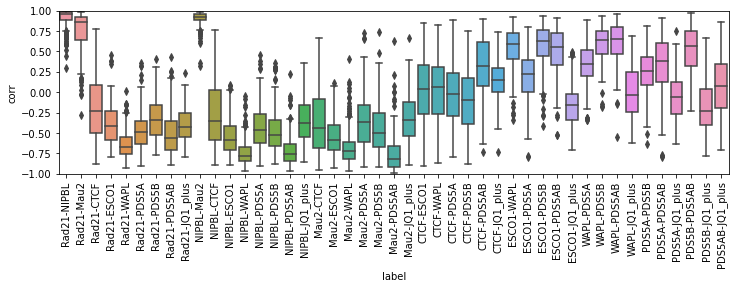

In [12]:
array = pd.DataFrame(columns=["corr", "label"])
for i in range(len(labels)):
        for j in range(i, len(labels)):
            l1 = labels[i]
            l2 = labels[j]
            if l1 != l2:
                a = corarray.loc[l1,l2].values
            
                d = pd.DataFrame(data=a, columns=["corr"])
                d["label"] = l1 + "-" + l2
                array = pd.concat([array, d], axis=0)

array["label"] = array["label"].replace('_merged', '', regex=True)
array["label"] = array["label"].replace('_72h', '', regex=True)
array["label"] = array["label"].replace('KD', '', regex=True)
plt.figure(figsize=(12, 3))
sns.boxplot(y='corr', x='label', data=array)
plt.ylim(-1,1)
plt.xticks(rotation=90)
plt.savefig("boxplot.csim.diffDRFregions.pdf")

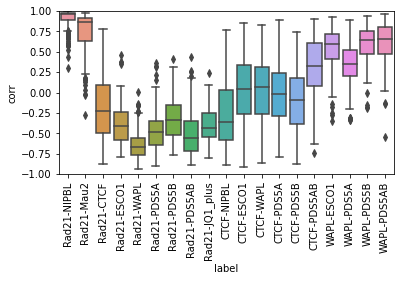

In [22]:
array = pd.DataFrame(columns=["corr", "label"])
for l1,l2 in [["Rad21KD_merged","NIPBLKD_merged"],
              ["Rad21KD_merged","Mau2KD"],
              ["Rad21KD_merged","CTCFKD_merged"],
              ["Rad21KD_merged","ESCO1KD_merged"],
              ["Rad21KD_merged","WAPLKD"],
              ["Rad21KD_merged","PDS5AKD_72h"],
              ["Rad21KD_merged","PDS5BKD"],
              ["Rad21KD_merged","PDS5ABKD"],
              ["Rad21KD_merged","JQ1_plus"],
              ["CTCFKD_merged","NIPBLKD_merged"],
              ["CTCFKD_merged","ESCO1KD_merged"],
              ["CTCFKD_merged","WAPLKD"],
              ["CTCFKD_merged","PDS5AKD_72h"],
              ["CTCFKD_merged","PDS5BKD"],
              ["CTCFKD_merged","PDS5ABKD"],
              ["CTCFKD_merged","NIPBLKD_merged"],
              ["WAPLKD","ESCO1KD_merged"],
              ["WAPLKD","PDS5AKD_72h"],
              ["WAPLKD","PDS5BKD"],
              ["WAPLKD","PDS5ABKD"],
             ]:
     a = corarray.loc[l1,l2].values
     d = pd.DataFrame(data=a, columns=["corr"])
     d["label"] = l1 + "-" + l2
     array = pd.concat([array, d], axis=0)

array["label"] = array["label"].replace('_merged', '', regex=True)
array["label"] = array["label"].replace('_72h', '', regex=True)
array["label"] = array["label"].replace('KD', '', regex=True)
plt.figure(figsize=(6, 3))
sns.boxplot(y='corr', x='label', data=array)
plt.ylim(-1,1)
plt.xticks(rotation=90)
plt.savefig("Fig4E.boxplot.csim.diffDRFregions.pdf")